In [1]:
#hide
#default_exp core
from nbdev import *

# Core

> The core functionality of the HECSS module is provided by the `HECSS` class which encapsulates the `HECSS_Sampler` factory function, which returns sampler as an iterator. The other functions in this module: `normalize_conf` and `write_dfset` are just utilities which are useful in typical use cases.

## `HECSS_Sampler` generator function

The implementation of the core functionality is centered around this generator function which yields samples from the thermal distribution at a given temperature.
This is more flexible but also more advanced technique. For every-day use it is better to employ `HECSS` class which facilitates more traditional interface and usage patterns using this function under the hood.

### Usage
    
A general usage scheme runs the sampler in the for loop as an iterator providing series of samples.
    
- `N`: number of requested samples, 
- `cryst` : structure to be calculated,
- `calc` : ASE calculator
- `T`: target temperature in Kelvin.

Loop variables:

- `n` : sample number
- `i` : sample configuration index (may not change between samples)
- `x` : displacement vector
- `f` : forces
- `e` : potential energy

The minimal main loop should be structured like this:
```python
sampler = HECSS_Sampler(cryst, calc, T)
for n, i, x, f, e in sampler:
    process_sample(n, i, x, f, e)
    if n > N :
        break
sampler.close()
```
This structure is well suited for the interactive use inside the notebook. It is possible in this setup to run few initial iterations to test if all works well and then continue the same loop by just increasing the `N` variable and re-running the above loop to continue the calculations.


Alternatively, if you know that you need particular number of iterations you can use the `N` parameter of the sampler to produce a particular number of configurations:
```python
confs = [sample for sample in HECSS_Sampler(cryst, calc, T, N=N)]
process_samples(confs)
```
This setup is better suited to command-line work, but in this case you cannot continue the iterations after the loop finishes.

These are minimal examples. Look at `VASP_Tutorial` and `LAMMPS_Tutorial` for more elaborated examples.


## `HECSS` class

Standard interface to the HECSS library. This class encapsulates the actual sampler implemented in the `HECSS_Sampler` generator funtion and provides main functionality of the library through the `generate` method.

### Usage

After creating `HECSS` object for the structure, calculator and temperature you call the `generate` method to obtain a list of samples of a given length.

In [2]:
#export
import sys
import ase
from ase import units
from ase.calculators import calculator
import scipy
from scipy import stats
from scipy.special import expit
import numpy as np
from numpy import log, exp, sqrt, linspace, dot
import ase.units as un
from tqdm.auto import tqdm
from itertools import islice

In [3]:
#export
def write_dfset(fn, c):
    '''
    Append displacement-force data from the conf to the fn file.
    The format is suitable for use as ALAMODE DFSET file.
    Optionaly you can provide configuration number in n.
    File need not exist prior to first call. 
    If it does not it will be created.
    '''
    n, i, x, f, e = c
    with open(fn, 'at') as dfset:
        print(f'# set: {n:04d} config: {i:04d}  energy: {e:8e} eV/at', file=dfset)
        for ui, fi in zip(x,f):
            print((3*'%15.7f ' + '     ' + 3*'%15.8e ') % 
                        (tuple(ui/un.Bohr) + tuple(fi*un.Bohr/un.Ry)), 
                        file=dfset)

In [4]:
# hide
# asap
from matplotlib import pylab as plt
from scipy import stats

def plot_hist(v, el, n, l=''):
    plt.hist(v, label=f'{el}{l}', bins='auto', alpha=0.2, density=True)
    m, s = stats.norm.fit(v)
    plt.axvline(v.mean(), ls='--', color=f'C{n}', label=f'{el}{l} = {m:.2f}+/-{s:.2f}')
    x = linspace(m-3*s, m+3*s, 100)
    plt.plot(x, stats.norm.pdf(x, m, s), ls='-', lw=1, color=f'C{n}')
    return m, s

In [5]:
#export
def HECSS_Sampler(cryst, calc, T_goal, width=1, maxburn=20, 
            N=None, w_search=True, delta_sample=0.01, sigma=2, xi=0,
            Ep0=None, modify=None, modify_args=None,
            directory=None, reuse_base=None, verb=True, pbar=None,
            priors=None, posts=None, width_list=None, xscale_list=None):
    '''
    Run HECS sampler on the system `cryst` using calculator `calc` at target
    temperature `T_goal`. The `delta`, `width`, `maxburn` and `directory` 
    parameters determine detailed aspects of the algorithm.

    This is a generator and cannot be used as regular function. 
    It is intended to be used as a source of the sequence of 
    configurations in the `for` loop and must be closed after 
    finishing the iteration. On the other hand, the iteration 
    may be continued if additional samples are required. 
    The state is preserved until the .close() method is called.
    
    INPUT
    -----
    cryst        : ASE structure to sample
    calc         : ASE calculator to use for potential energy evaluations
    T_goal       : Target temperature in Kelvin
    width        : initial width of the position distribution, relative 
                   to the heurestic value defined inside function                  
    maxburn      : max number of burn-in steps
    N            : Number of iterations. If None (default) the generator never stops.
    w_search     : Run search for initial w. If false start from whatever 
                   is passed as width.
    delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    sigma        : Range around E0 in sigmas to stop w-serach mode
    xi           : strength of the amplitude correction term [0-1]
    Ep0          : T=0 energy (base, no dstortions), if None (default) calculate E0.
    modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    modify_args  : dictionary of extra arguments to pass to modify function
    directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    verb         : print verbose progress messages for interactive use
    pbar         : tqdm progress bar object. If None (default) there will be no output.
    
    **Output parameters**
    
    priors       : Output parameter. If not None, store in passed list the sequence of priors.
    posts        : Output parameter. If not None, store in passed list the sequence of posteriors.
    width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    xscale_list  : Output parameter. If not None, store in passed list the array of xscales (normalized).

    OUTPUT
    ------
    The generator yields samples from the thermodynamic distribution at T=T_goal as tuples
    (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample must be repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    
    
    if pbar:
        pbar.set_postfix(Sample='initial')
    
    def smpl_print(r=0):
        max_r = 15
        if pbar:
            if i==0:
                pbar.set_postfix(Sample='burn-in', n=k, w=w, alpha=alpha, dE=f'{(e_star-E_goal)/Es:+6.2f} sigma', xs=f'{xscale.std():6.3f}')
            else :
                pbar.set_postfix(xs=f'{sqrt(xscale.std()/xscale.mean()):6.3f}', config=f'{i:04d}', a=f'{100*i/n:5.1f}%', w=w, 
                                 w_bar=f'{np.mean([_[0] for _ in wl]) if wl else w:7.3f}',
                                 alpha=f'{alpha:7.1e}', rej=f'{r:4d}')
        elif pbar is None :
            if i==0:
                print(f'Burn-in sample {sqrt(xscale.std()/xscale.mean()):6.3f}:{k}  w:{w:.4f}  alpha:{alpha:7.1e}  dE:{(e_star-E_goal)/Es:+6.2f} sigma', end='\n')
            else :
                print(f'Sample {sqrt(xscale.std()/xscale.mean()):6.3f}:{n:04d}  a:{100*i/n:5.1f}%  w:{w:.4f}  <w>:{np.mean([_[0] for _ in wl]) if wl else w:.4f}' 
                      +  f' alpha:{alpha:10.3e} ' + f' rej:{r:d}', end='\n')
            sys.stdout.flush()
        else :
            pass

    nat = len(cryst)
    dim = (nat, 3)

    xscale = np.ones(dim)
    mu = np.ones(dim)
    xi = max(0,xi)
    xi = min(1,xi)

    if Ep0 is None:
        if reuse_base is not None:
            calc0 = reuse_base
            Ep0 = calc0.get_potential_energy()
        else:
            Ep0 = cryst.get_potential_energy()
    
    E_goal = 3*T_goal*un.kB/2
    Es = np.sqrt(3/2)*un.kB*T_goal/np.sqrt(nat)   
    
    P = stats.norm.pdf
    Q = stats.norm
    
    # This comes from the fitting to 3C-SiC case
    w_scale = 1.667e-3 * (T_goal**0.5) #(T_goal**0.47)
    
    w = width
    w_prev = w

    x = Q.rvs(size=dim, scale=w * w_scale)
    
    if width_list is None :
        wl = []
    else :
        wl = width_list

    if priors is None:
        priors = []

    if posts is None:
        posts = []

    i = 0
    n = 0
    
    if directory is None :
        basedir = f'calc/T_{T_goal:.1f}K'
    else :
        basedir = directory

    cr = ase.Atoms(numbers = cryst.get_atomic_numbers(), 
                   cell=cryst.get_cell(),
                   scaled_positions=cryst.get_scaled_positions(),
                   pbc=True, calculator=calc)
    
    if pbar:
        pbar.set_postfix(Sample='initial')

    cr.set_positions(cryst.get_positions()+x)
    try :
        cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
    except AttributeError :
        pass

    if modify is not None:
        e, f = modify(cr, cryst, 'i', *modify_args)
    else:
        e = cr.get_potential_energy()
        f = cr.get_forces()
    
    e = (e-Ep0)/nat    
    
    k = 0
    r = 0
    alpha = 0
    
    if pbar:
        pbar.set_postfix(Sample='burn-in')

    while N is None or n < N:
        if verb and (n>0 or k>0):
            smpl_print(r)

        if xscale_list is not None:
            xscale_list.append(mu)

        assert xscale.shape==dim
        assert (xi*xscale + np.ones(dim)-xi).shape==dim

        x_star = (xi*xscale + np.ones(dim)-xi) * Q.rvs(size=dim, scale=w * w_scale ) 

        cr.set_positions(cryst.get_positions()+x_star)
        try :
            cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
        except AttributeError :
            pass

        try :
            if modify is not None:
                e_star, f_star = modify(cr, cryst, 's', *modify_args)
            else:
                e_star = cr.get_potential_energy()
                f_star = cr.get_forces()
        except calculator.CalculatorError:
            continue
        
        e_star = (e_star-Ep0)/nat
        
        wl.append((w,e_star))

        if i==0 :
            delta = 10 * delta_sample
        else :
            delta = delta_sample
        w_prev = w

        if w_search :
            w = w*(1-2*delta*(expit((e_star-E_goal)/Es/3)-0.5))
            if i==0 and abs(e_star-E_goal) > sigma*Es :
                # We are in w-search mode but still far from E_goal
                # Continue
                k += 1
                if k>maxburn :
                    print(f'\nError: reached maxburn ({maxburn}) without finding target energy.\n'+
                        f'You probably need to change initial width parameter (current:{w})' +
                        f' to a {"higher" if (e_star-E_goal)<0 else "lower"} value.')
                    return
                # Continue searching for proper w
                continue

        priors.append((n, i, x_star, f_star, e_star))

        if i==0 :
            # We are in w-search mode and just found a proper w
            # switch to sampling mode by making sure the sample is accepted
            # 2 is larger than any result of np.random.rand()
            alpha = 2 
            # clean up the w table
            wl.clear()
            prior_len=1
        else :
            # Sampling mode
            alpha = P(e_star, E_goal, Es) / P(e, E_goal, Es)

            if len(priors) > 3 :
                # There is no sense in fitting priors to normal dist if we have just 2-3 samples
                # The 4 samples is still rather low but seems to work well enough
                if  len(priors) > 1.1*prior_len:
                    # Re-fit the prior only if we get 10% more samples
                    pfit = stats.norm.fit([_[-1] for _ in priors])
                    prior_len = len(priors)
                
                # Take into account estimated transition probability
                alpha *= stats.norm.pdf(e, *pfit)/stats.norm.pdf(e_star, *pfit)

        if np.random.rand() < alpha:
            x = x_star
            e = e_star
            f = f_star
            i += 1
            r = 0
        else:
            # Sample rejected - stay put
            r += 1
        
        n += 1
        
        smpl_print(r)
        if pbar:
            pbar.update()

        if posts is not None :
            posts.append((n, i-1, x, f, e))
            
        mu = np.abs(f*x)/(un.kB*T_goal)
        xscale *= (1-2*delta*(expit(5*(mu-1))-0.5))
        xscale /= xscale.mean()

        yield n, i-1, x, f, e
    
    if pbar:
        pbar.close()

In [6]:
#export
class HECSS:
    '''
    Class facilitating more traditional use of the `HECSS_Sampler` generator.
    '''
    def __init__(self, cryst, calc, T_goal, width=1, maxburn=20, 
                 N=None, w_search=True, delta_sample=0.01, sigma=2, xi=0,
                 Ep0=None, modify=None, modify_args=None,
                 directory=None, reuse_base=None, verb=True, 
                 pbar=True, priors=None, posts=None, width_list=None, xscale_list=None):
        if pbar is True:
            self.pbar = tqdm(total=N)
        else:
            self.pbar = pbar
        self.N=N
        self.total_N=0
        self.T=T_goal
        self.sampler = HECSS_Sampler(cryst, calc, T_goal, 
                                     width=width, maxburn=maxburn, 
                                     w_search=w_search, 
                                     delta_sample=delta_sample, 
                                     sigma=sigma, xi=xi,
                                     Ep0=Ep0, modify=modify, modify_args=modify_args,
                                     pbar=self.pbar,
                                     directory=directory,
                                     reuse_base=reuse_base, verb=verb, 
                                     priors=priors, posts=posts, 
                                     width_list=width_list, xscale_list=xscale_list)
    
    def generate(self, N=None, sentinel=None, **kwargs):
        '''
        Generate and return the list of N samples provided 
        by the `HECSS_Sampler` generator in `self.sampler`.
        `sentinel` parameter is a call-back function 
        which is called on every sample to decide if the
        iteration should be stopped early. If it returns
        True the iteration will be stopped and the current 
        list of samples is returned. The sentinel is called
        *after* generating each sample (i.e. first time after 
        first sample is produced). This may take considerable 
        time at the start since first initial and burn-in 
        samples must be produced.
        '''
        if N is None:
            N = self.N
           
        # This is a workaround for the miss-design of tqdm 
        # where bool() for total==None returns error 
        if self.pbar is not None and self.pbar is not False:
            self.pbar.reset(self.total_N + N)
            self.pbar.update(self.total_N)

        smpls = [] 
        for smpl in self.sampler:
            smpls.append(smpl)
            if sentinel is not None and sentinel(smpl, smpls, **kwargs):
                break
            if len(smpls) >= N:
                #self.pbar.close()
                break
        self.total_N += len(smpls)
        return smpls

In [7]:
# asap

from ase.build import bulk
import asap3
from hecss.monitor import plot_stats

# Local copy of model from OpenKIM-models from 2019
model = 'data/Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# Model form 2021 OpenKIM-models package
#model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_004'
sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))

0it [00:00, ?it/s]

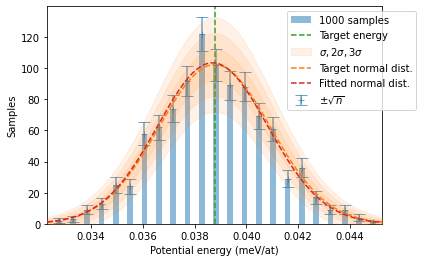

In [8]:
# asap

T = 300
xsl = []
sampler = HECSS(cryst, asap3.OpenKIMcalculator(model), T, delta_sample=0.01, xscale_list=xsl, xi=1)

# asap

N = 1_000
samples = sampler.generate(N)
plot_stats(samples, T, sqrN=True)

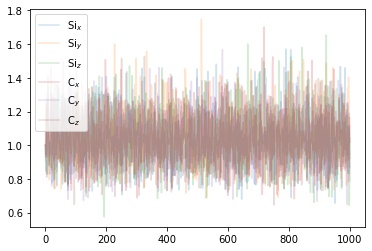

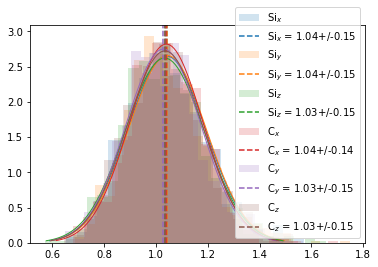

In [9]:
# hide
# asap
elems = cryst.get_chemical_symbols()
#plt.semilogy()
for n, el in enumerate(set(elems)):
    for i in range(3):
        plt.plot(np.array([x[np.array(elems)==el].mean(axis=0) for x in xsl])[:,i], 
                 label=f'{el}$_{"xyz"[i]}$', alpha=0.2)
plt.legend();
plt.show()

elems = cryst.get_chemical_symbols()
for n, el in enumerate(set(elems)):
    v = np.array([x[np.array(elems)==el].mean(axis=0) for x in xsl[:]])
    for i in range(3):
        plot_hist(v[:,i], el, 3*n+i, f'$_{"xyz"[i]}$')
plt.legend();

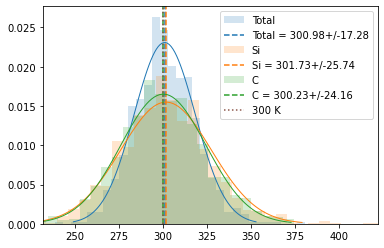

In [10]:
# hide
# asap

m_smpl = samples[:]

elems = cryst.get_chemical_symbols()
vir = np.array([-s[2]*s[3] for s in m_smpl])/un.kB
nat = len(elems)
m, s = plot_hist(vir.reshape((len(vir), -1)).mean(axis=1), 'Total', 0)
for n, el in enumerate(set(elems)):
    plot_hist(vir[:, np.array(elems)==el, :].reshape((len(vir), -1)).mean(axis=1), el, n+1)
plt.axvline(T, ls=':', color='C5', label=f'{T:.0f} K')
plt.xlim(m - 4*s, m + 7*s)
plt.legend();

In [11]:
# hide
# asap

m = np.mean([_[-1] for _ in samples])
s = np.std([_[-1] for _ in samples])

s_target = np.sqrt(3/2)*units.kB*T/np.sqrt(len(cryst))

# We should get N samples
assert len(samples) == N

# The mean really should be inside target 2*sigma around T
assert np.abs(m - 3*T*units.kB/2) < 2*s_target

# And sigmas should be within 20% of each other
assert np.abs(s/s_target - 1)<0.2

In [12]:
# hide
# asap

T = 300
N = 100
sampler = HECSS(cryst, asap3.OpenKIMcalculator(model), T,  N=N)

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
# hide
# asap

smpl = sampler.generate()
smpl += sampler.generate()
smpl += sampler.generate(20)
assert len(smpl) == (2*N+20)

In [14]:
#export
def normalize_conf(c, base):
    '''
    Normalize the configuration `c` relative to the basic structure `base`.
    Normalization is performed by "nuwrapping" the displacements of atoms
    when they cross the periodic boundary conditions in such a way that the
    atoms are not "jumping" from one side of the cell to the other. 
    
    E.g. if the atom at r=(0,0,0) goes to the relative position (-0.01, 0, 0)
    it is "wrapped" by PBC to the r=(0.99, 0, 0). Thus if we naiively calculate
    the displacement we will get a large positive displacement (0.99 of the cell 
    vector) instead of a small negative one. 
    
    This function reverses that process making the positions suitable for 
    differentiation. The positions may be part of a continous trajectory or
    just independent configurations. This makes it impossible for described 
    procedure to work if the displacements are above 1/2 of the unit cell.
    For sefety this implementation is limited to displacements < 1/3 of the 
    unit cell. If any coordinate changes by more then 1/3 the function
    will rise an AssertionError exception.
    
    This implementation is not suitable for tracking positions in the system
    with systematic drift (e.g. long MD trajectory with non-perfect momentum
    conservation). For stronger implementation suitable for such cases look
    at dxutils package.
    '''
    cell = base.get_cell()
    spos = c.get_scaled_positions()
    bspos = base.get_scaled_positions()

    # Unwrap the displacement relative to base
    sdx = spos - bspos
    sht = (sdx < -0.5)*1 - (sdx > 0.5)*1
    sdx += sht

    # Check if fractional displacements are below 1/3
    assert (abs(sdx) < 1/3).all()

    # Calculate unwrapped spos
    spos = bspos + sdx

    # Return carthesian positions, fractional positions
    return dot(spos,cell), spos

In [15]:
# hide
from ase.build import bulk
from numpy import allclose

# Use structure with most of the atoms 
# on the surface of the unit cell: rocksalt
b = bulk('NaCl', 'rocksalt', a=3.6, cubic=True).repeat((3,3,3))
c = bulk('NaCl', 'rocksalt', a=3.6, cubic=True).repeat((3,3,3))

# Displace the atoms
c.rattle(stdev=0.5, seed=42)

# Store unwrapped positions
unwrapped = c.get_scaled_positions(wrap=False)

# Wrap the positions
c.set_scaled_positions(c.get_scaled_positions(wrap=True))

# Check if the reversal worked
assert allclose(unwrapped, normalize_conf(c,b)[1])